# Perturbation cost trajectories for different models for different classes of adversarials (defended against vs. not defended against)

In [ ]:
import os
os.chdir("../")
import sys
import json
from argparse import Namespace
import numpy as np
from sklearn import metrics
from sklearn.metrics import pairwise_distances as dist
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper')

import provable_robustness_max_linear_regions.data as dt
from generate_perturbation_cost_trajectories import calculate_perturbation_cost_data
from utils import NumpyEncoder

## Plot settings:

In [7]:
SMALL_SIZE = 8
MEDIUM_SIZE = 18
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text', usetex=True)

# dictionary that maps color string to 'good looking' seaborn colors that are easily distinguishable
colors = {
    "orange": sns.xkcd_rgb["yellowish orange"],
    "red": sns.xkcd_rgb["pale red"],
    "green": sns.xkcd_rgb["medium green"],
    "blue": sns.xkcd_rgb["denim blue"],
    "yellow": sns.xkcd_rgb["amber"],
    "purple": sns.xkcd_rgb["dusty purple"],
    "cyan": sns.xkcd_rgb["cyan"]
}

## Calculate perturbation cost data:
Estimated runtime (if no file with data is present): < 1 hour

In [3]:
def load_from_json(file_name):

    if not os.path.exists("res/" + file_name + ".json"):
        return None
    else:
        with open("res/" + file_name + ".json", 'r') as fp:
            return json.load(fp)
        
def save_to_json(dictionary, file_name):
        
    if not os.path.exists("res"):
        os.makedirs("res")

    with open("res/" + file_name + ".json", 'w') as fp:
        json.dump(dictionary, fp, cls = NumpyEncoder)

# have to be enough points, so that there are actually adversarial examples in all classes
n_points = 1000
perturbation_cost_data = load_from_json("pert_cost_data_for_different_hp_classes_n_points={}".format(n_points))

model_path = "provable_robustness_max_linear_regions/models/mmr+at/2019-02-17 01:54:16 dataset=mnist nn_type=cnn_lenet_small p_norm=inf lmbd=0.5 gamma_rb=0.2 gamma_db=0.2 ae_frac=0.5 epoch=100.mat"

if not perturbation_cost_data:
    
    perturbation_cost_data = dict()
    
    file_name = model_path.split("/")[3]
    model_name = file_name.split(".mat")[0]
    
    args = Namespace()

    args.dataset = "mnist"
    args.n_points = n_points
    args.model_path = model_path
    args.adversarial_model_paths = [model_path]
    args.nn_type = "cnn"
    args.norms = ["inf"]
    args.noise_types = ["gaussian"]
    args.noise_sizes = [None]
    args.splits = [{"inf": [0.0, 0.1], "2": [0.0, 0.3]}, {"inf": [0.1, np.inf], "2": [0.3, np.inf]}]
    args.save = False
    args.plot = False

    file_name = model_path.split("/")[3]
    model_name = file_name.split(".mat")[0]
    perturbation_cost_data[model_name] = calculate_perturbation_cost_data(args)
    
    save_to_json(perturbation_cost_data, "pert_cost_data_for_different_hp_classes_n_points={}".format(n_points))

## Plot:

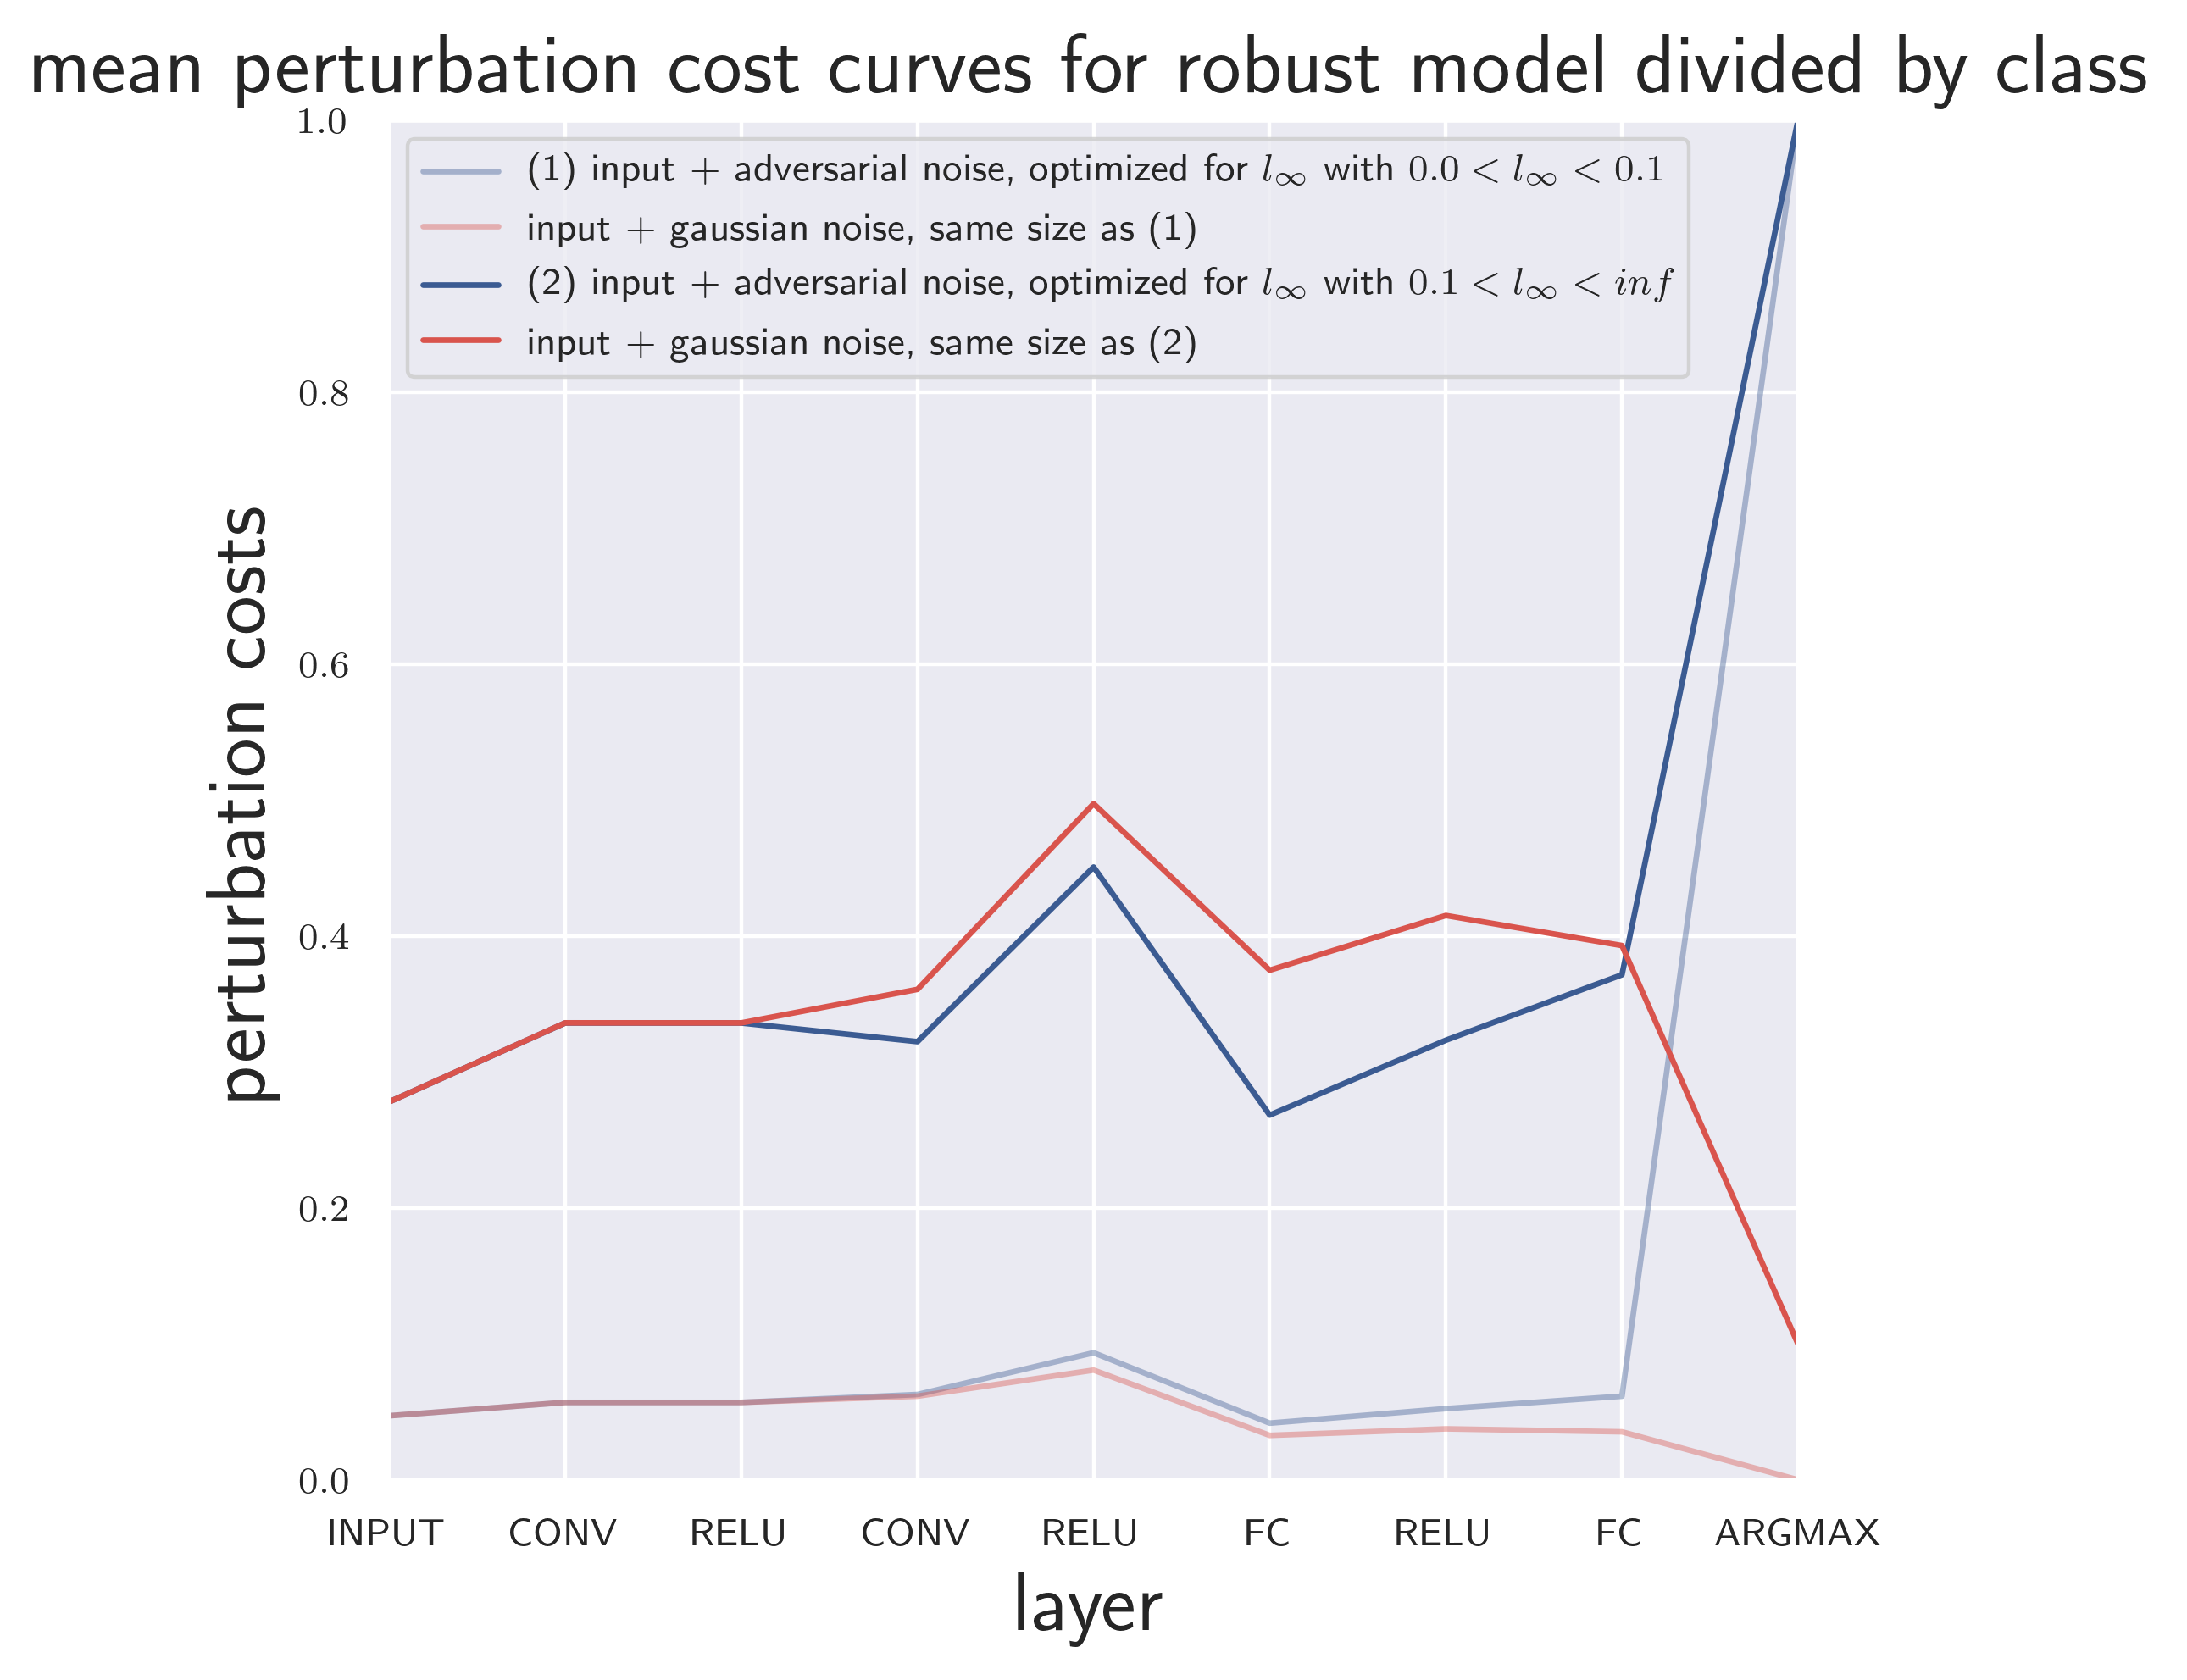

In [8]:
# name to save the plot
save_name = "fig_pc_croce_divided_by_class"

model_name = "2019-02-17 01:54:16 dataset=mnist nn_type=cnn_lenet_small p_norm=inf lmbd=0.5 gamma_rb=0.2 gamma_db=0.2 ae_frac=0.5 epoch=100"
base_color_dict = {"adv":{"inf": colors["blue"], "2": colors["green"]}, "noise":{"inf": colors["red"], "2": colors["yellow"]}}

# number of model types and parameter combinations
n_cols = 1
n_rows = 1

fig, ax = plt.subplots(n_rows, n_cols, figsize = (6 * n_cols, 5 * n_rows), dpi=400)

linestyle = "-"
base_color_dict = {"adv":{"inf": colors["blue"], "2": colors["green"]}, "noise":{"inf": colors["red"], "2": colors["yellow"]}}
norm_to_latex = {"inf":"\infty", "2":"2"}

for j, split in enumerate([{"inf": [0.0, 0.1], "2": [0.0, 0.3]}, {"inf": [0.1, np.inf], "2": [0.3, np.inf]}]):

    pert_cost_norm = "inf"
    perturbation_norm = "inf"
    noise_type = "gaussian"
    noise_size = str(None)
    split_str = json.dumps(split)

    pert_costs_adv = np.array(perturbation_cost_data[model_name][model_name][pert_cost_norm][perturbation_norm][noise_type][noise_size][split_str]["pert_costs_1"])
    pert_costs_noise = np.array(perturbation_cost_data[model_name][model_name][pert_cost_norm][perturbation_norm][noise_type][noise_size][split_str]["pert_costs_2"])

    lower_bound = split[perturbation_norm][0]
    upper_bound = split[perturbation_norm][1]

    linestyle = "-"

    ax.plot(np.mean(pert_costs_adv, axis=0), c=base_color_dict["adv"][perturbation_norm], linestyle=linestyle, label="({}) input + adversarial noise, optimized for ${}$ with ${} < {} < {}$".format(j+1, "l_{\infty}", str(lower_bound), "l_{\infty}", str(upper_bound)), alpha=0.4+(j*0.6))
    ax.plot(np.mean(pert_costs_noise, axis=0), c=base_color_dict["noise"][perturbation_norm], linestyle=linestyle, label="input + gaussian noise, same size as ({})".format(j+1), alpha=0.4+(j*0.6))


ax.set_xlim(0.0, 8.0)
ax.set_ylim(0.0, 1.0)

ax.set_xticks(np.arange(0, 9.0, 1.0))
ax.set_xticklabels(["INPUT", "CONV", "RELU", "CONV", "RELU", "FC", "RELU", "FC", "ARGMAX"])

ax.set_xlabel("layer")
ax.set_ylabel("perturbation costs")

ax.legend()
ax.set_title("mean perturbation cost curves for robust model divided by class")

fig.tight_layout()
fig.savefig('res/{}.pdf'.format(save_name))